In [1]:
from IPython.display import display
import numpy as np
%matplotlib nbagg
import matplotlib.pyplot as plt
import sympy as sy
sy.init_printing()
from functools import reduce
from operator import mul
from itertools import accumulate
from sympy.utilities.lambdify import lambdify
from sympy.functions.special.bsplines import bspline_basis, bspline_basis_set

def prod(iterable):
    return reduce(mul, iterable, 1)
 
monome = lambda one, zero: sy.simplify((z-zero)/(one - zero))
binome = lambda one, zeros: monome(one, zeros[0]) * monome(one, zeros[1])
polynom = lambda one, zeros: prod((monome(one, zero) for zero in zeros))

#####################################################################
# Degree of flowes
ndeg = 1
#####################################################################

# Number of segments
nseg = 3

z = sy.symbols('z')
# Delta_i are the length of the various segments
delta = [sy.symbols('Delta_%s' % iseg, positive=True) for iseg in range(nseg)]
cumdelta = list(accumulate(delta))

# Location of the nodes
ziold = sy.symbols('z_0:%d' % (nseg + 1))
subs ={ziold[0]: sy.S(0)}
zi = [sy.S(0),]
for iseg in range(nseg):
    subs[ziold[1+iseg]] = subs[ziold[iseg]] + delta[iseg]
    zi.append(subs[ziold[1+iseg]])
display(zi, subs)

def mydisplay(el):
    if ndeg*nseg < 2:
        display(el)
    else:
        display(el[:2])
        print('...')

eps = sy.symbols('varepsilon', positive=True)
nodes = [sy.S(0),]
for indz, el in enumerate(zi[1:-1]):
    nodes.extend([el - eps*delta[indz], el + eps * delta[indz+1]])
nodes.append(zi[-1])
eval_at_nodes = lambda expr: [expr.subs(z, node).subs(eps, 0) for node in nodes]

#####################################################################
# Defining some helpers to build the various basis functions

def continuous_Lagrange_elements_set(d, zi):
    """
    Home made constructor for the set of continuous Lagrange elements of degree d
    """
    lFun = []
    nseg = len(zi) - 1
    delta = [zi[iseg+1] - zi[iseg] for iseg in range(nseg)]
    for iseg in range(nseg):
        # Knots within the segment
        innerz = [zi[iseg] + delta[iseg] * ind / (d) for ind in range(d+1)]
        cond = sy.And(z >= zi[iseg], z <= zi[iseg+1])
        for ipol in range(d+1):
            tmp = list(innerz).copy()
            tmpi = tmp.pop(ipol)
            # Current polynomial vanishes at all knots, except the ipol-th
            fun = sy.Piecewise((polynom(tmpi, tmp), cond), (0, True))
            if (iseg > 0) and (ipol == 0):
                # Merge with condition defined in previous segment
                last = lFun.pop(-1)
                args = [last.args[0],] + list(fun.args)
                fun = sy.Piecewise(*args)
            lFun.append(fun)
    return lFun

def my_bspline_basis_set(d, knots, x):
    """
    Home made constructor for the set of basic splines for a given degree and knots list.
    Sympy bspline_basis_set has troubles to generate the basis needed
    for high-order extension of the Golo procedure.
    """
    knots = tuple(sy.sympify(k) for k in knots)
    n_knots = len(knots)
    n_intervals = n_knots - 1
    n_splines = n_knots - d - 1
    splines = [None,] * n_splines
    dOrders = {}
    Chi = [sy.And(knots[n] <= x, x < knots[n+1])
           for n in range(n_intervals)] + [True,]

    for order in range(d+1):
        if order == 0:
            dOrders[0] = tmp = [sy.S(0),] * (n_intervals)
            for n in range(n_intervals):
                exprs = [sy.S(0),] * (n_intervals + 1)
                exprs[n] = sy.S(1)
                conds = list(zip(exprs, Chi))
                tmp[n] = sy.Piecewise(*conds)
        else:
            dOrders[order] = tmp = [sy.S(0),] * (n_intervals - order)
            for j in range(n_knots - 1 - order):
                if knots[j+order] > knots[j]:
                    coef = (x - knots[j]) / (knots[j+order] - knots[j])
                    tmp[j] += coef * dOrders[order-1][j]
                if knots[j+order+1] > knots[j+1]:
                    coef = (knots[j+order+1] - x) / (knots[j+order+1] - knots[j+1])
                    tmp[j] += coef * dOrders[order-1][j+1]

    return [sy.piecewise_fold(el) for el in dOrders[d]]

#####################################################################

def info(option, full=False):
    """
    Print :
    - the first basis functions for efforts and flowes"
    - the derivatives of the first effort basis functions
    - the values of the latter at the segments boundaries
    and plots all these functions.
    """
    lPsi = option['Psi']
    lPhi = option['Phi']
    print("Flowes")
    mydisplay(lPsi)
    print("Efforts")
    mydisplay(lPhi)

    ldPhi = option['dPhi'] = [phi.diff(z).factor() for phi in lPhi]
    if full:
        print('Derivative of efforts basis functions')
        mydisplay(ldPhi)

        print('Values of derivatives on segment boundaries')
        mydisplay([eval_at_nodes(dphi) for dphi in ldPhi])
        
    fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 6))
    subsnum = {d: i for i, d in enumerate(delta, start=1)}
    tmax = max([d.subs(subsnum) for d in cumdelta])
    t = np.linspace(0, float(tmax), 1024)

    for ax, funcs, label, typ in zip(axs, (lPhi, lPsi, ldPhi),
                                     (r'\Phi', r'\Psi', r'd\Phi'),
                                     ('Efforts', 'Flows', 'Efforts\nderivatives')):
        values = [lambdify(z, func.subs(subsnum), 'numpy')(t) for func in funcs]
        for ind, data in enumerate(values):
            ax.plot(t, data+ind*.01, label='$%s_%d$' % (label, ind))
        ax.legend(ncol=2, loc='right', fontsize='x-small', frameon=True)
        ax.set_ylabel(typ, fontsize='x-small')

    axs[-1].set_xticks([float(el.subs(subsnum)) for el in zi])
    axs[-1].set_xticklabels([r'$%s$' % str(el).replace('Delta', '\Delta') for el in zi])
    fig.suptitle('$N_{deg}=%d$' % ndeg)

# Basis functions

The procedure described by Golo does not fully rely on a variational form of the PDE. In contrast to what is usually done in mixed FEM, the choice of basis functions explicitly uses the strong equality relating efforts and flows $ f = J_1 de$, i.e., the spaces for efforts anf flowes must be consistent in order to satisfy the equality locally. In the case given by Golo (1st-order external derivative in the interconnection operator), the linear span of the derivative of the efforts basis functions must match the space of fluxes. This may be satisfied by several possibilities.
Hereafter, two options are presented, but other may also be possible.

## Option 1: Choosing continuous Lagrange elements for efforts

Efforts are discretized as classical Lagrange elements of degree $ N_{deg} + 1 $ :

  * piecewise $\mathcal{C}^{\infty}$ (e.g. $\mathcal{C}^{\infty}$ on each of the $N_{seg}$ intervals),

  * only $\mathcal{C}^{0}$ at the global level, so that derivative can be discontinuous.


Flowes must then match the linear span of the derivatives of the classical Lagrange elements, i.e., piecewise-defined polynomials that may be discontinuous at nodes. This corresponds to the discontinuous Lagrange elements of degree $N_{deg}$.


Finally there are:
  * $N_{comp}\times(N_{deg}+1)\times N_{seg}$ degrees of freedom (dofs) for flowes,
  * $N_{comp}\times((N_{deg}+1)\times N_{seg}+1)$ dofs for efforts.

Flowes


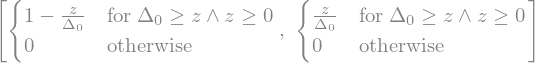

...
Efforts


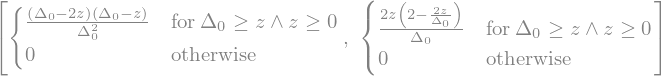

...


<IPython.core.display.Javascript object>


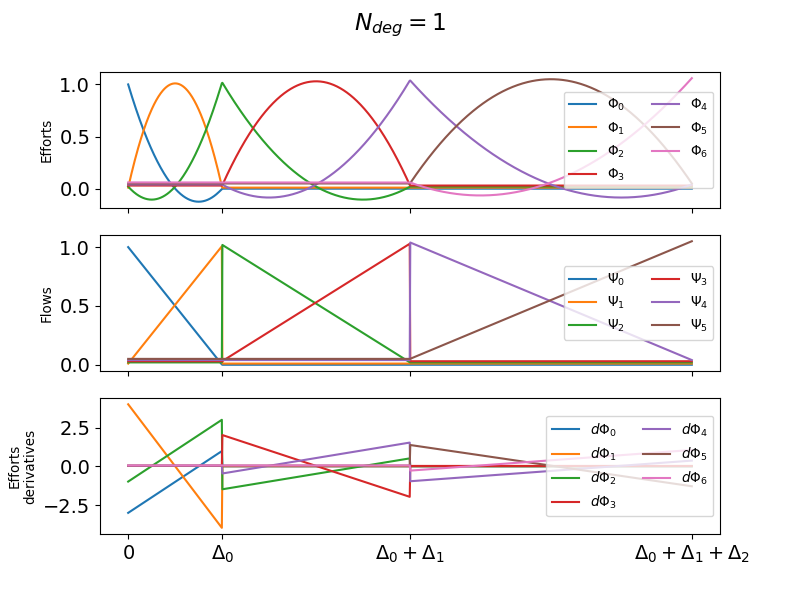

In [2]:
# Efforts: Continuous Lagrange elements of degree ndeg+1 (manually defined)
lPhi1 = continuous_Lagrange_elements_set(ndeg+1, zi)

# Flowes: Discontinuous polynomials of degree ndeg
# Basic Splines of **order** ndeg+1 (i.e., made of polynomials of degree ndeg)
knots = []
for knot in zi:
    knots.extend([knot,]*(ndeg+1))
lPsi1 = bspline_basis_set(ndeg, knots, z)

dOptions = {1: {'Phi': lPhi1, 'Psi': lPsi1}}

info(dOptions[1])

## Option 2: Choosing continuous Lagrange elements for flowes

On the contrary, we want flowes to be classical Lagrange elements of degree $N_{deg}$, so that they are globally continuous by construction.
    
Efforts must then be in a restricted subset piecewise-defined polynomials of degree $N_{deg}+1$. Their derivatives must be globally continuous to match the flowes space, i.e., the efforts must be globally $\mathcal{C}^1$-continuous.
We can build a basis for this space by using the set of B-splines of degree $N_{deg}+1$ with duplicated ($N_{deg}$ times) first and last points and single-multiplicity inner knots, which ensures the derivative is continuous (at least for $N_{deg}\ge 1$).

Finally there are:
  * $N_{comp}\times(N_{deg}\times N_{seg}+1)$ degrees of freedom (dofs) for flowes,
  * $N_{comp}\times(N_{deg}\times N_{seg}+2)$ dofs for efforts.

Flowes


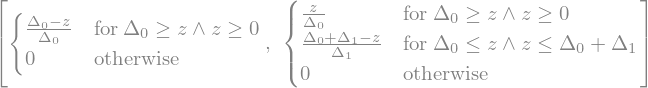

...
Efforts


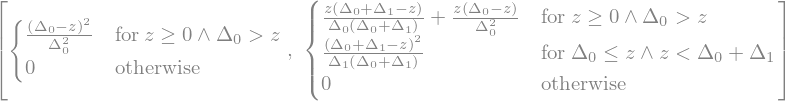

...


<IPython.core.display.Javascript object>


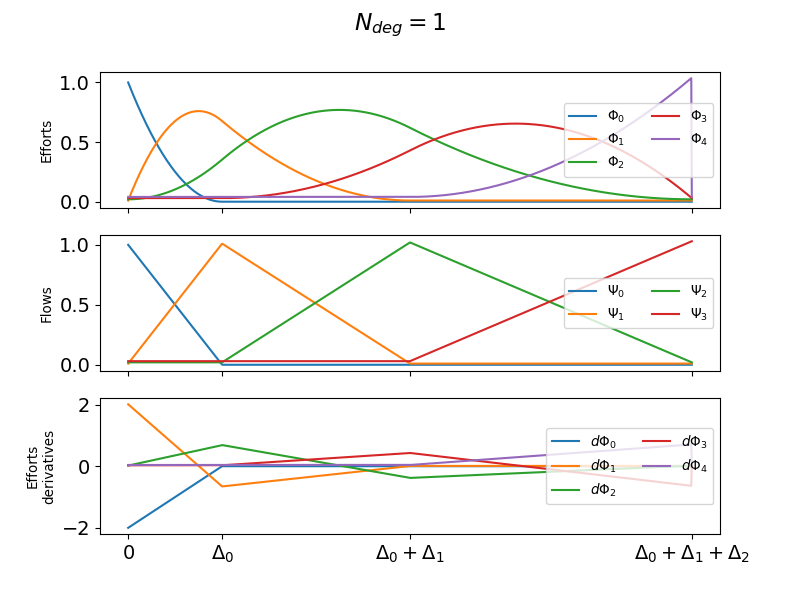

In [3]:
# Flowes: Continuous polynomials of degree ndeg
lPsi2 = continuous_Lagrange_elements_set(ndeg, zi)

# Efforts: BSplines of degree ndeg+1
knots = [zi[0],]*(ndeg+2)
for knot in zi[1:-1]:
    knots.extend([knot,]*(ndeg+0))
knots.extend([zi[-1],] * (ndeg+2))
lPhi2 = my_bspline_basis_set(ndeg+1, knots, z)

dOptions[2] = {'Phi': lPhi2, 'Psi': lPsi2}
info(dOptions[2])

# Discretization of the structure

We know use the parametrization of flowes and efforts:
  * $(f_n^i)_{n=0..N-1}$ the coefficients of the expansion of the $i$-th component of flow vector on the flow basis functions $(\Psi_n)_{n=0..N-1}$
  * $(e_m^j)_{m=0..N}$ the coefficients of the expansion of the $j$-th component of effort vector on the effort basis functions $(\Phi_m)_{m=0..N}$

in the equation $f=A\cdot de$, so that, for all component index $i$:
$$
f^i(z) = \sum_{n=0}^{N-1} f_n^i \Psi_n(z)
    = \sum_{j=1}^{N_{comp}} A_{i, j} de^j(z)
    = \sum_{j=1}^{N_{comp}} A_{i, j} \sum_{m=0}^N e_m^j d\Phi_m(z)
    = \sum_{m=0}^N \left(\sum_{j=1}^{N_{comp}} A_{i, j} e_m^j \right) d\Phi_m(z).
$$

For simple cases, we might directly substitute the derivatives $d\Phi_m(z)$ by their expansion on the $(\Psi_n)_{n=0..N-1}$ basis.
Otherwise, we can project by performing scalar products with each of the flow basis functions:
$$ \forall\ 0\leq n' \lt N, \qquad
<\Psi_{n'}, f^i> = \sum_{n=0}^{N-1} f_n^i <\Psi_{n'}, \Psi_n(z)>
    = \sum_{m=0}^N \left(\sum_{j=1}^{N_{comp}} A_{i, j} e_m^j \right) <\Psi_{n'}, d\Phi_m(z)>
$$
which may be rewritten matricially as $ N\cdot\mathcal{F}^{T} = R\cdot \mathcal{E}^{T}\cdot A^T$ with
$$
\mathcal{F}_{i,n} = f_n^i,\qquad
\mathcal{E}_{j,m} = e_m^j,\qquad
N_{n', n} = <\Psi_{n'}, \Psi_n>,\qquad
R_{n', m} = <\Psi_{n'}, d\Phi_m>
$$.
It is important to notice that choosing orthonormal flow basis functions greatly simplifies the problem by reducing $N$ to the identity matrix. The computation of flow dofs from effort dofs is then explicit.

## Evaluation of the matrices
$$
N_{n', n} = <\Psi_{n'}, \Psi_n> = \int_\Omega \Psi_{n'}(z) \Psi_n(z),
\qquad
M_{k,l} = \int_\Omega \psi_k \Phi_l
\text{ and }
R_{k,l} = \int_\Omega \psi_k \partial_z\Phi_l$$


Option 1


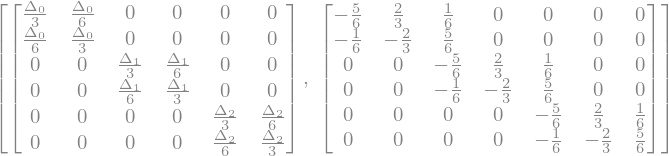

Option 2


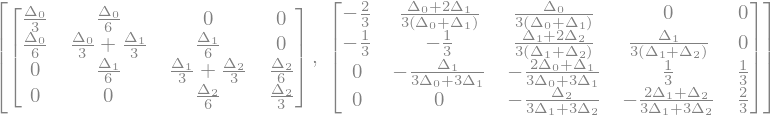

In [4]:
for key, opt in dOptions.items():
    lPsi = opt['Psi']
    lPhi = opt['Phi']
    ldPhi = opt['dPhi']
    
#     M = sy.Matrix([[sy.integrate(sy.piecewise_fold((psi*phi)),
#                                  (z, zi[0], zi[-1])).expand()
#                     for iphi, phi in enumerate(lPhi)]
#                    for ipsi, psi in enumerate(lPsi)])       
#     M.simplify()  # inplace
    R = sy.Matrix([[sy.integrate(sy.piecewise_fold((psi*dphi)),
                                 (z, zi[0], zi[-1])).expand()
                    for iphi, dphi in enumerate(ldPhi)]
                   for ipsi, psi in enumerate(lPsi)])       
    R.simplify()
    N = sy.Matrix([[sy.integrate(sy.piecewise_fold((psi0*psi1)),
                                 (z, zi[0], zi[-1])).expand()
                    for ipsi1, psi1 in enumerate(lPsi)]
                   for ipsi0, psi0 in enumerate(lPsi)])     
    N.simplify()
    print('Option %d' % key)
    display([N, R, ])

Note the block diagonal structure of matrix $N$, with either non-overlapping (option 1) or overlapping (option 2) blocks which directly relates to the continuity of the flowes at the inner nodes of the mesh.